<a href="https://colab.research.google.com/github/matczap/SimBa-HybridSims/blob/main/HybSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SIMLE SIMBA HYBRID SIMULATOR
# By MC
# Version 17.10.2022 
import numpy as np
import matplotlib.pyplot as plt
import os

# REFPROP setup
!pip install CoolProp

import CoolProp.CoolProp as CP

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44.2 MB 1.7 MB/s 


In [2]:
# FUNTION DEFINITIONS

def area(dia):
  return 0.25 * np.pi * dia ** 2    # equation for area

def mass_to_alfa(temp, vol, mass):
  dliq = CP.PropsSI("D","T",temp,"Q",0,"NitrousOxide")  # density of saturated liquid
  #print("Initial liquid N2O density: ", dliq," kg/m^3")
  dvap = CP.PropsSI("D","T",temp,"Q",1,"NitrousOxide")  # density of saturated vapour
  #print("Initial vapour N2O density: ", dvap," kg/m^3")
  #mliq = (vol - mass/dvap) / (1/dliq - 1/dvap)          # mass of liquid (via AspireSpace "Hybrid motor design")
  #print("Initial liquid N2O mass: ", mliq," kg")
  #alfa = (mass - mliq) / mass
  alfa = (mass - dliq * vol)/(dvap * vol - dliq * vol)
  return alfa

def alfa_to_mass(temp, vol, alfa):
  dliq = CP.PropsSI("D","T",temp,"Q",0,"NitrousOxide")  # density of saturated liquid
  # print("Initial liquid N2O density: ", dliq," kg/m^3")
  dvap = CP.PropsSI("D","T",temp,"Q",1,"NitrousOxide")  # density of saturated vapour
  # print("Initial vapour N2O density: ", dvap," kg/m^3")
  mass = dvap*alfa*vol + dliq*(1-alfa)*vol    # mass of liquid
  return mass

def N2O_properties_sat(temp):
  d_liq = CP.PropsSI("D","T",temp,"Q",0,"NitrousOxide")       # density of saturated liquid
  d_vap = CP.PropsSI("D","T",temp,"Q",1,"NitrousOxide")       # density of saturated vapour
  h_liq = CP.PropsSI("H","T",temp,"Q",0,"NitrousOxide")       # enthalpy of saturated liquid
  h_vap = CP.PropsSI("H","T",temp,"Q",1,"NitrousOxide")       # enthalpy of saturated vapour
  p_vap = CP.PropsSI("P","T",temp,"Q",1,"NitrousOxide")       # pressure of saturated vapour
  #vis_liq = CP.PropsSI("V","T",temp,"Q",0,"NitrousOxide")   # viscosity of sat. liquid FIX IT !!!
  vis_liq = 1.37 * 1e-5
  s_liq = CP.PropsSI("S","T",temp,"Q",0,"NitrousOxide")       # enthropy of sat. liquid
  cp_liq = CP.PropsSI("C","T",temp,"Q",0,"NitrousOxide")       # specific heat of saturated liquid
  return d_liq, d_vap, h_liq, h_vap, p_vap, vis_liq, s_liq, cp_liq

def N2O_properties_liq(energy, mass, volume):
  U = energy / mass
  d = mass / volume
  temp = CP.PropsSI("T","U",U,"D",d,"NitrousOxide")

  d_liq = N2O_properties_sat(temp)[0]
  h_liq = N2O_properties_sat(temp)[2]
  p_vap = N2O_properties_sat(temp)[3]
  vis_liq = N2O_properties_sat(temp)[4]
  s_liq = N2O_properties_sat(temp)[5]

  alfa = mass_to_alfa(temp, volume, mass)
  return temp, d_liq, h_liq, p_vap, vis_liq, s_liq, alfa

def nikurdase(Re):
  return 0.0076 * pow(3170/Re, 0.165) / (1 + pow(3170/Re, 7)) + 16/Re

def dyer_injector(cpres, inj_dia, lden, inj_pdrop, hl, manifold_P, vpres, ls, numinj):
    # Models the mass flow rate of (initially liquid) n2o through a single
    # injector orifice using the 2-phase model proposed by Dyer et al
    #
    # source: PWR HybridSim
    #############################
    # VARIABLES
    # cpres - combustion chamber pressure
    # inj_dia - injector diameter
    # lden - liquid density
    # inj_pdrop - pressure drop across the injector
    # hl - liquid enthalpy
    # manifold_P - manifold pressure
    # vpres - vapour pressure
    # ls - liquid enthropy
    # numinj - number of injector holes

    # TODO: change variable names to used in other parts

    inj_pdrop_og = 0

    A=area(inj_dia)*numinj
    Cd = 0.6  # Waxman et al, adapted for square edged orifices
    # single-phase incompressible mass flow rate:
    # See Ref 1, page 8, Eqn 2.13
    mdot_spi = Cd * A * np.sqrt(2 * lden * inj_pdrop)
    if cpres>vpres: #may occur in hgly pressurized tank
        return mdot_spi
    
    if inj_pdrop < 3e5:
        #print('accuracy warning: injector pdrop so low that'
        #      '2-phase Dyer model no longer applies. '
        #      'approximating with linear pdrop/mdot characteristic')
        inj_pdrop_og = inj_pdrop
        inj_pdrop = 3e5
    
    # get downstream spec. enthalpy and density
    h2   = CP.PropsSI("H","P",cpres,"S",ls,"NitrousOxide")
    rho2 = CP.PropsSI("D","P",cpres,"S",ls,"NitrousOxide")

    # mass flow rate by homogenous equilibrium model:
    # See Ref 1, page 9, Eqn 2.14
    
    mdot_hem = Cd * A * rho2 * np.sqrt(2 * (hl - h2))

    # non-equilibrium parameter k (∝ ratio of bubble growth
    #                              time and liquid residence time)
    # See Ref 1, page 9, Eqn 2.17
    k = np.sqrt((manifold_P - cpres) / (vpres - cpres))

    # mass flow rate by Dyer model
    # See Ref 1, page 11, Eqn 2.21
    mdot_ox = ((k * mdot_spi) + mdot_hem) / (1 + k)

    if 0 < inj_pdrop_og < 3e5:
        mdot_ox *= inj_pdrop_og / (3e5)
    
    return mdot_ox

def initial_U(temp, mliq, mvap):
  u_liq = CP.PropsSI("U","T",temp,"Q",0,"NitrousOxide")
  u_vap = CP.PropsSI("U","T",temp,"Q",1,"NitrousOxide")
  U = u_liq * mliq + u_vap * mvap
  return U

First section contains data input from user

In [3]:
# all units SI


# outside parameters (environment)
AIR_TEMP = 20 + 273.15        # [K] ambient temperature
AIR_PRES = 1013 * 100         # [Pa] atmospheric pressure

# run tank dimensions (inside rocket)
RUN_VOLU = 10 * 1e-3          # [m^3] run-tank volume

RUN_DIAM = 135 * 1e-3      # [m] run-tank diameter
RUN_LENG = 900 * 1e-3      # [m] run-tank length
if RUN_VOLU == 0:
  RUN_VOLU = area(RUN_DIAM) * RUN_LENG # [m^3] run-tank volume 
print("Tank volume: ",RUN_VOLU*1e3, " l")

RUN_TEMP = 20 + 273.15         # [K] run-tank temperature
RUN_GASF = 0.12                # [-] run-tank gas percentage

# main oxidizer line parameters
RUN_OUT_D = 19 * 1e-3          # [m] outlet diameter
RUN_OUT_L = 50 * 1e-3          # [m] outlet length
MOX_DIAM = 17 * 1e-3           # [m] Main Oxidizer Valve ball diameter
MOX_LENG = 17 * 1e-3           # [m] Main Oxidizer Valve ball length

# injector dimensions
INJ_NUMB = 10                 # [-] number of injector orifices
INJ_DIAM = 2.2 * 1e-3               # [m] diameter of single injector orifice

# oxidizer parameters (initial)
OXI_MASS = 7              # [kg] oxidizer mass
OXI_TEMP = 20 + 273.15    # [K] oxidizer temperature
OXI_PRES = N2O_properties_sat(OXI_TEMP)[3] # [Pa] oxidizer pressure
print("Initial oxidizer parameters: ", OXI_TEMP, " [K], ", OXI_PRES*1e-5, " [bar]")

if OXI_MASS:
  print("Using known oxidizer mass: ",OXI_MASS," kg")
  RUN_GASF = mass_to_alfa(OXI_TEMP,RUN_VOLU, OXI_MASS)
  print("Vapour percentage: ",RUN_GASF)
else:
  print("Using known vapour percentage: ", RUN_GASF)
  OXI_MASS = alfa_to_mass(OXI_TEMP, RUN_VOLU, RUN_GASF)
  print("Nitrous oxide mass: ", OXI_MASS, " kg")

# combustion chamber parameters
COMB_PRES = 2 * 10e5        # [Pa] designed combustion pressure


Tank volume:  10.0  l
Initial oxidizer parameters:  293.15  [K],  3.8432041302347  [bar]
Using known oxidizer mass:  7  kg
Vapour percentage:  0.1357063956851853


In [4]:
# simulation initialization
T_INIT = 0        # [s] simulation initial time
T_END  = 7        # [s] simulation end time
DT = 1e-3         # [s] time step

VEC_LENG = int((T_END - T_INIT)/DT)  # [samp] data vector length
print("Data vector length: ", VEC_LENG, " samples")

# initialization of data vectors
time_sim = np.zeros(VEC_LENG)
step = np.zeros(VEC_LENG)
m_dot_ox = np.zeros(VEC_LENG)
alfa = np.zeros(VEC_LENG)
mass_ox = np.zeros(VEC_LENG)
mass_liq = np.zeros(VEC_LENG)
mass_vap = np.zeros(VEC_LENG)
pres_tank = np.zeros(VEC_LENG)
temp_tank = np.zeros(VEC_LENG)
pres_drop = np.zeros(VEC_LENG)
pres_cham = np.zeros(VEC_LENG)

print("Vectors initialized")

time_sim[0] = T_INIT
alfa[0] = RUN_GASF
mass_ox[0] = OXI_MASS
mass_liq[0] = OXI_MASS * (1-RUN_GASF)
mass_vap[0] = OXI_MASS * RUN_GASF
pres_tank[0] = OXI_PRES
temp_tank[0] = OXI_TEMP

# supplemental variables (N2O parameters etc.)
d_liq, d_vap, h_liq, h_vap, p_vap, vis_liq, s_liq, cp_liq = N2O_properties_sat(temp_tank[0])
feed_area = area(RUN_OUT_D)
U = initial_U(temp_tank[0], mass_liq[0], mass_vap[0])
depletion_flag = 1
m_vapourized = 0.0001

for i in range(VEC_LENG-1):
  step[i] = i
  time_sim[i] = i * DT
  if step[i]%1000 == 0:
    print("Simulation time: ", time_sim[i], " s")

  if mass_liq[i] < 0.01:
    if depletion_flag:
      print("Liquid depleted at: ", time_sim[i], " s")
      depletion_flag = 0
    mass_liq[i+1] = 0 

  if m_dot_ox[i] > 0 and mass_liq[i] > 0:
    flow_speed = m_dot_ox[i] / (d_liq * feed_area)        # nitrous flow speed
    entry_loss = 0.5 * d_liq * (flow_speed ** 2)          # nitrous pressure loss in tank outlet
    reynolds = d_liq * flow_speed * RUN_OUT_D / vis_liq    # reynolds number
    f = nikurdase(reynolds)                               # using Nikurdase model for friction

    # pressure loss in feed system
    pres_drop_feed = 0.25 * f * d_liq * (flow_speed ** 2) * RUN_OUT_L / RUN_OUT_D

    #pressure loss in ball valve
    pres_drop_valve = 0.5 * d_liq * (flow_speed ** 2) * MOX_LENG / MOX_DIAM     # fix for ball valve kv calculation

    pres_drop[i] = pres_drop_feed + pres_drop_valve
    pres_manifold = p_vap - pres_drop[i]

  else:
    pres_manifold = p_vap

  pres_cham[i] = COMB_PRES                         # to expand

  pres_drop_inj = pres_manifold - pres_cham[i]     # later change for calculated pressure in C chamber

  # model oxidizer outflow
  if mass_liq[i] > 0.01:  
    # liquid phase operation
    m_dot_ox[i+1] = dyer_injector(pres_cham[i], INJ_DIAM, d_liq, pres_drop_inj, h_liq, pres_manifold, p_vap, s_liq, INJ_NUMB)
    print(m_dot_ox[i])

    mass_ox[i+1] = mass_ox[i] - m_dot_ox[i] * DT
    U_new = U - h_liq * m_dot_ox[i] * DT

    delta_Q = m_vapourized * h_vap * DT
    delta_temp = - delta_Q / (mass_liq[i] * cp_liq)

    temp_tank[i+1] = temp_tank[i] + delta_temp
    d_liq, d_vap, h_liq, h_vap, p_vap, vis_liq, s_liq, cp_liq = N2O_properties_sat(temp_tank[i+1])
    alfa_temp = mass_to_alfa(temp_tank[i+1], RUN_VOLU, mass_ox[i+1])

    mass_old = mass_liq[i] - m_dot_ox[i] * DT

    pres_tank[i+1] = p_vap
    mass_liq[i+1] = mass_old
    mass_vap[i+1] = mass_ox[i+1] * alfa_temp
    alfa[i+1] = alfa_temp
    
    mass_new = (RUN_VOLU - mass_ox[i+1]/d_vap) / (1/d_liq - 1/d_vap)
    #mass_new = mass_ox[i+1] * (1 - alfa_temp)
    print(time_sim[i], mass_ox[i+1], temp_tank[i+1], m_vapourized, mass_old, mass_new, alfa[i+1])

    m_vapourized = mass_old - mass_new

    #print(time_sim[i], U_new, mass_ox[i], temp_tank[i])
    #temp_tank[i+1], d_liq, h_liq, p_vap, vis_liq, s_liq, alfa_temp = N2O_properties_liq(U_new, mass_ox[i+1], RUN_VOLU)
    #alfa[i+1] = alfa_temp
    #pres_tank[i+1] = p_vap
    #mass_liq[i+1] = mass_ox[i+1] * (1-alfa[i+1])
    #mass_vap[i+1] = mass_ox[i+1] * alfa[i+1]
  else:
    break


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
3.384 3.2408290541203004 293.12201150849546 0.2104660066120747 2.2908842843239943 2.0806418428876094 0.7350575428194787
1.0402760028242264
3.3850000000000002 3.239788778117476 293.11097609370967 0.21024244143638482 2.28984400832117 2.079825022678342 0.7351900437116922
1.0401526769769838
3.386 3.238748625440499 293.09994320367946 0.21001898564282806 2.288803855644193 2.0790082160837735 0.7353224975086556
1.0400293373677298
3.387 3.2377085961031313 293.0889128478012 0.20979563956041947 2.287763826306825 2.078191422790084 0.7354549042853065
1.03990598415429
3.388 3.236668690118977 293.0778850354491 0.209572403516741 2.286723920322671 2.077374642484709 0.735587264116436
1.0397826174942968
3.3890000000000002 3.2356289075014826 293.06685977597505 0.20934927783796198 2.2856841377051764 2.0765578748563307 0.7357195770766922
1.0396592375451357
3.39 3.2345892482639376 293.0558370787086 0.20912626284884572 2.2846444784676314 2.07574

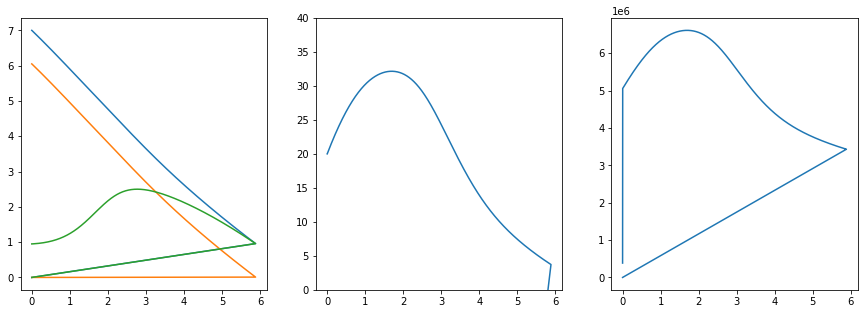

In [5]:
# result plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(time_sim, mass_ox)
plt.plot(time_sim, mass_liq)
plt.plot(time_sim, mass_vap)

plt.subplot(1,3,2)
plt.plot(time_sim, temp_tank - 273.15)
plt.ylim(0,40)

plt.subplot(1,3,3)
plt.plot(time_sim, pres_tank)